# CS5284 Project : Package Recommendation (Group 19)


## Motivation
When developing a project, developers often invest significant time researching potential packages to integrate for various reasons. The overwhelming number of options available in established software ecosystems like NPM or Maven can make it challenging to identify the most suitable package amidst the overwhelming choices.

During our research, we observed that software projects and their dependencies naturally form graph-like structures due to the many-to-many relationships between projects and packages. This inherent connectivity makes them a perfect candidate for graph-based machine learning algorithms, enabling the creation of a package recommendation model to address this challenge effectively.

## Goal:
The goal of this project is to build a model that analyzes metadata about a project, such as its existing dependencies, the topic it is based on, and other contextual information, to recommend new dependencies it could use. To achieve this, we employ graph-based machine learning algorithms, including PageRank and Graph Content Filtering, leveraging the natural graph structure of software projects. Additionally, we construct baseline models using non-graph techniques such as Memory-based Collaborative Filtering and Low Rank Model-based (Matrix Factorization) Collaborative Filtering. These baselines provide a point of comparison to contextualize and evaluate the performance of the graph-based models.

One notable aspect of our project is that we did not find any existing work specifically addressing this problem, either using Graph ML or non-graph approaches. Consequently, we were unable to identify any publicly available datasets suitable for our model. To overcome this challenge, we created our own dataset by collecting and processing data from platforms like GitHub and NPM. This dataset includes metadata about projects, their dependencies, their themes, etc. serving as the foundation for training and evaluating our recommendation model


### Prerequisites
Some additional libraries required by our project




In [ ]:
!pip install python-dotenv sentence-transformers 


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached sentence_transformers-3.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.46.3-py3-none-any.whl.metadata (44 kB)
  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.20.3-cp312-none-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
Using cached sentence_transformers-3.3.1-py3-none-any.whl (268 kB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached transformers-4.46.3-py3-none-any.whl (10.0 MB)
Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl (273 kB)
Using cached safetensors-0.4.5-cp312-none-win_amd64.whl (286 kB)
Using cached tokenizers-0.20.3-cp312-none-win_amd64.whl (2.4 MB)


### Initialization

In [1]:
import requests
import json
import pandas as pd
import time
from collections import defaultdict
from datetime import datetime
import numpy as np
from dotenv import load_dotenv
import os
import logging
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import diags
import scipy
from sentence_transformers import SentenceTransformer
from typing import Union, List
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import MaxAbsScaler
from itertools import combinations
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline


logger = logging.getLogger(__name__)
logging.basicConfig(filename='log.log', level=logging.INFO)
logger.info('Started')


In [2]:
# Setting up file paths

project_dataset_path = "dataset/Project_Data"
package_dataset_path = "dataset/Package_Data"


project_dependencies_json = f"{project_dataset_path}/Project_dependencies_50_topics.json"
project_details_csv = f"{project_dataset_path}/Github_Project_Details_50_Topic.csv"

package_dependencies_json = f"{package_dataset_path}/package-features.json"
package_features_cf_json = f"{package_dataset_path}/package-feats-cf.json"

### Utility functions

In [5]:
def convert_str_to_list(string):
    string = string.strip()
    if not string.startswith("[") or not string.endswith("]"):
        return []
    
    string = string[1:-1].strip()
    
    if not string:
        return []
    
    keywords = [item.strip().strip("'").strip('"') for item in string.split(",")]
    
    return [keyword for keyword in keywords if keyword]


# Functions to clean data loaded from JSON

def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps.keys() if p in valid]
        

# Function to create a list of packages from cleaned data

def create_package_list(data):
    packages = set()
    for deps in data.values():
        packages.update(deps)
    return list(packages)

def load_data_from_json(filename):
    return json.load(open(filename, "r"))


## Project Dependencies

Getting details of real-world user projects from Github using Github's REST API to create a dataset of projects to act as the users for our recommendation models. 

Data Source: [Github Rest API](https://docs.github.com/en/rest?apiVersion=2022-11-28)

> **NOTE** - Dataset creation can be a time-consuming process so we have included all the data files in the `dataset` folder included in the zip file. To run the models using data from these files please go to section `Memory Based Collaborative Filtering` [link](#memory-based-collaborative-filtering).       **But be sure to run the code sections defined above**

In [2]:
load_dotenv(dotenv_path='app.env')

token = os.getenv('GITHUB_TOKEN')

#### Generating Github Fine grained token

If you wish to run the Github APIs for dataset creation, please generate your own finegrained token and place it in app.env


Running the dataset collection process without the token is too slow.  

[Token Creation Steps](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens#creating-a-fine-grained-personal-access-token)

In [13]:
# Read the CSV file
file_path = 'dataset/Application_types.csv'
df = pd.read_csv(file_path)

# Convert the 'Keyword' column to a list
topic_list = df['Keyword'].tolist()

# Display the list
print(topic_list)


def write_json_data(fileName, data):
    with open(fileName, 'w') as file:
        json.dump(data, file, indent=4)


def append_json_data(fileName, data):
    # Try to read existing data if the file exists
    try:
        with open(fileName, 'r') as file:
            existing_data = json.load(file)
    except FileNotFoundError:
        existing_data = []  # Initialize as an empty list if the file doesn't exist

    # Append new data to existing data
    existing_data.append(data)

    # Write the updated data back to the file
    with open(fileName, 'w') as file:
        json.dump(existing_data, file, indent=4)


def sleep_if_rate_exhausted(response):
    core_limits = response.headers._store
    rate_left = core_limits['x-ratelimit-remaining'][1]

    if int(rate_left) > 0:
        return

    reset_time = core_limits['x-ratelimit-reset'][1]
    reset_timestamp = datetime.fromtimestamp(int(reset_time))
    current_time = datetime.now()
    sleep_duration = (reset_timestamp - current_time).total_seconds()
    print(f"Rate limit reached. Sleeping until reset at {reset_timestamp}")
    time.sleep(sleep_duration+5)  # Sleep until reset time + some delay time
    print("Rate limit reset. Resuming requests.")


['Dashboard', 'CMS', 'E-commerce', 'Portfolio', 'Blog', 'Chatbot', 'Social Network', 'Messaging', 'Forum', 'Community', 'News', 'Wiki', 'File Manager', 'Analytics', 'Project Management', 'Task Manager', 'Calendar', 'Notes', 'Kanban', 'ERP', 'CRM', 'POS', 'Inventory', 'To-do', 'Video Streaming', 'Music Player', 'Photo Gallery', 'Weather', 'Finance', 'Budget Tracker', 'Expense Tracker', 'Banking', 'Travel', 'Booking', 'Reservation', 'Hotel Management', 'Real Estate', 'Job Portal', 'Classroom', 'Learning Management System', 'Online Exam', 'Survey', 'Poll', 'E-learning', 'Quiz', 'Recipe', 'Cookbook', 'Portfolio', 'Resume Builder', 'Event Management', 'Gaming', 'Game Tracker', 'Game Leaderboard', 'VR', 'AR', '3D Modeling', 'Fitness', 'Workout Tracker', 'Health Tracker', 'Diet Planner', 'Meal Planner', 'Meditation', 'Habit Tracker', 'Productivity', 'Chat', 'Collaboration', 'Help Desk', 'Customer Support', 'Feedback', 'Documentation', 'Startup', 'Portfolio', 'Map', 'Geo-location', 'Travel Gui

### Getting projects from Github based on topic

Here we defined a function to get github repo details of various user projects. We diversify the types of projects by searching for projects covering different topics. To avoid the noise of abandoned and incomplete projects we only pick projects which have a star count of >50. We also only get projects with a Primary Language of Javascript to narrow down the scope of our project.

In [14]:
def get_github_projects_of_topic(num_results,num_pages, topic):
    headers = {'Authorization': f'token {token}'}
    url = 'https://api.github.com/search/repositories'
    params = {
        'q': f'language:JavaScript {topic} stars:>50',
        'sort': 'stars',
        'order': 'desc',
        'per_page': num_results,
        'page': num_pages
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        projects = [
            {
                'id': item['id'],
                'name': f"{item['name']}+{item['owner']['login']}",  # Combine name and owner
                'owner': item['owner']['login'],  # Keep the owner column
                'watchers': item['watchers_count'],
                'created_at': item['created_at'],
                'updated_at': item['updated_at'],
                'size': item['size'],
                'stars': item['stargazers_count'],
                'open_issues_count': item['open_issues_count'],
                'language': item['language'],
                'forks': item['forks'],
                'description': item['description'],
                'topics': item['topics']
            } 
            for item in data['items']
        ]
        
        
        
        for project in projects:
            if project['id'] in projects_set:
                continue
            
            unique_projects.append(project)
            projects_set.add(project['id'])
            if(len(unique_projects) >= total_num_results):
                break

        

        return unique_projects, response,len(unique_projects),len(projects)

    else:
        print(f"Error: {response.status_code}")
        return None, response

In [ ]:
topic_dict = {}
num_topics = 50
projects_set = set()
for i in range(num_topics):
    currentTopic = topic_list[i]
    num_unique_results = 0
    num_pages=1
    unique_projects = []
    prev_results=0
    num_results = 10
    total_num_results = num_results
    while True:
        projects, response, num_unique_results, num_of_results_from_API = get_github_projects_of_topic(num_results=num_results, num_pages=num_pages,topic=currentTopic)
        
        if projects is not None:
            topic_dict[currentTopic] = projects
        
        if num_unique_results >= total_num_results:
            break
        
        if num_of_results_from_API == prev_results:
            break
        
        prev_results = num_of_results_from_API
        
        if num_results<100:
            num_results+=10
        else:
            num_pages+=1
        
        
        sleep_if_rate_exhausted(response)
        
    sleep_if_rate_exhausted(response)
    
print(topic_dict)

After we have the details of the projects we wish to use for our dataset. We get the SBOM of those projects, which contains all the dependencies used by the project. Considering the scope of our project, we only focus on dependencies coming from NPM

In [ ]:
def get_Sbom_of_projects(repo_df):
    headers = {'Authorization': f'token {token}'}
    url = 'https://api.github.com/repos/'
    owner = repo_df['owner']
    repo_name_owner = repo_df['name']
    repo = repo_df['name'].split('+')[0]
    url = url + f'{owner}/{repo}/dependency-graph/sbom'

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        packages = data['sbom']['packages']
        # Extract npm packages with name and version
        pkg_dict = defaultdict(dict)
        data_written = False
        for package in packages:
            if package['externalRefs'][0]['referenceLocator'].startswith('pkg:npm'):
                try:
                    if len(package['versionInfo']) > 0:
                        if 'versionInfo' in package:
                            if package['name'].startswith('npm:'):
                                data_written = True
                                sbom_dict[repo_name_owner][package['name'][4:]] = package['versionInfo']
                            else:
                                data_written = True
                                sbom_dict[repo_name_owner][package['name']] = package['versionInfo']
                except:
                    continue
        
        if not data_written:
            print(repo_df)
            print(packages[0]['externalRefs'][0]['referenceLocator'])
            remove_projects.append(repo_df)
    else:
        print(f"Error: {response.status_code}")
        remove_projects.append(repo_df)

    return response


remove_projects = []
sbom_dict = defaultdict(dict)
ctr = tctr = 1
for topic, projects in topic_dict.items():
    for project in projects:
        response = get_Sbom_of_projects(project)
        sleep_if_rate_exhausted(response)
    print(f'{ctr}. {topic} done')
    ctr+=1



In [ ]:
os.makedirs(project_dataset_path, exist_ok=True)
write_json_data(project_dependencies_json, sbom_dict)

In [ ]:
print(len(remove_projects))


def check_if_in_remove(project_id):
    for i in remove_projects:
        if i['id'] == project_id:
            return True
    return False

In [ ]:
all_projects = []

filename = project_details_csv
for topic, projects in topic_dict.items():
    for project in projects:
        # Add the topic as a new field in each project dictionary
        if not (check_if_in_remove(project["id"])):
            project['topic'] = topic
            all_projects.append(project)
        else:
            print(project)

# Convert the list of all projects with topics into a DataFrame
df = pd.DataFrame(all_projects)

# Save the DataFrame to a CSV file
df.to_csv(f'{filename}', index=False)

print(f"Data saved to {filename}.csv")

## Package Dependencies

We aim to use the package dependencies of the projects as the content to be recommended. In this section, we get features about the packages such as download count, keywords and description. These features will later on also be used to measure similarity between packages for recommendation.

To obtain all information required for packages we will be using the [NPM REST API](https://github.com/npm/registry/blob/main/docs/REGISTRY-API.md)

**NOTE**

The NPM API provides a separate end-point for fetching download counts of a package. There is also the limitation of scoped packages i.e. ones containing an `@`, not being able to be processed in bulk. Therefore, once we obtain all the metadata for packages we split them into `unscoped` and `scoped` packages and process them separately. Unscoped packages can be processed in chunks of size 128 (the max limit supported by the API), while scoped packages need to be processed individually.

We make use of concurrency using `ThreadPoolExecutor` to parallelize and speed up the data retrieval but it can still take upto 25-25 mins to fetch data for ~16000 packages across ~400 projects.

In [ ]:
# UTILITY FUNCTIONS

def filter_valid_package_names(packages):
    packages = set(packages)
    remove = set()
    for package in packages:
        if (not package.startswith('@')) and (not package[0].islower()):
            remove.add(package)
                
    return packages - remove


def retryable(func, *args, max_retries=3, on_fail=None, **kwargs):
    for i in range(max_retries):
        try:
            return func(*args, **kwargs)
        except requests.exceptions.ConnectionError as e:
            print(
                f"[ERROR] Connection error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
        except RuntimeError as e:
            print(f"[ERROR] Runtime error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
            break

    return on_fail


def convert_time_to_epoch(timestamp):
    timestamp = timestamp.replace('Z', '+00:00')
    timestamp = datetime.fromisoformat(timestamp)
    return datetime.strftime(timestamp, '%s')


def save_data_as_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)
        







# Function to fetch package data from NPM API

def fetch_package_data(package, base_url="https://registry.npmjs.org/"):
    res = requests.get(base_url + package)
    data = res.json()
    
    if res.status_code == 200:
        if 'dist-tags' not in data:
            print(f"{package} is unpublished")
            return {}
    
        latest_version = data["dist-tags"]["latest"]
        
        package_details = {
            "keywords": data.get("keywords", []),
            "description": data.get("description", ""),
            "creation_date": data["time"]["created"],
            # "dependencies": data["versions"][latest_version].get("dependencies", {}), 
            # "devDependencies": data["versions"][latest_version].get("devDependencies", {}), 
            # "peerDependencies": data["versions"][latest_version].get("peerDependencies", {}), 
        }
        
        return package_details
    
    else:
        return -res.status_code
    
    
# Function to concurrently fetch data for a list of packages

def fetch_package_list(packages, max_workers=10):
    package_feats = {}
    failed_packages = []
    
    with ThreadPoolExecutor() as executor:
        futures = { executor.submit(retryable, fetch_package_data, package, on_fail=-1): package for package in packages }
        
        print("Downloading Packages. Check log.log file for progress")
        print("tail -f ./log.log")
        
        for i, future in enumerate(as_completed(futures)):
            package = futures[future]
            result = future.result()
            
            if type(result) is int and result < 0:
                failed_packages.append(package + '\n')
            elif result == {}:
                failed_packages.append(f'{package} is unpublished' + '\n')
                logger.error(f"{i+1}/{len(futures)} {package} failed")
            else:
                # result["dependencies"] = list(result["dependencies"].keys()) if result["dependencies"] != {} else []
                package_feats[package] = result
                logger.info(f"{i+1}/{len(futures)} {package} success")
    
    with open("./log.txt", "w") as f:
        print(f"Successfully fetched {len(package_feats)}/{len(packages)} packages. Check ./log.txt for failed packages.")
        f.writelines(failed_packages)
        
    return package_feats


# Functions to load project data to build package space

def load_project_data(file="./GithubScrape/Data/60_topics_JS/append_dependencies_40_7.json"):
    data = json.load(open(file, "r"))
    for p, deps in data.items():
        data[p] = list(filter_valid_package_names(list(deps.keys())))
    
    return data


def build_package_space(projects):
    package_space = set()
    for project, deps in projects.items():
        package_space.update(deps)
        
    return package_space



# Functions to get download counts in bulk or for single package

def get_download_counts_bulk(packages):
    url = f"https://api.npmjs.org/downloads/point/last-year/{','.join(packages)}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return [(p, d['downloads']) for p,d in data.items()]
        
    else:
        print(f"[ERROR] failed for chunk {packages} with status code {res.status_code}")
        return -1
        

def get_download_count(package):
    url = f"https://api.npmjs.org/downloads/point/last-year/{package}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return data['downloads']
    
    else:
        print(f"[ERROR] failed for package {package} with status code {res.status_code}")
        return -1


# Functions to divide packages into scoped and unscoped and get download counts

def fetch_download_counts_unscoped(packages, max_workers=5):
    chunks = []
    for i in range(0, len(packages), 128):
        chunks.append(packages[i:i + 128])
    print("Number of chunks for unscoped:", len(chunks))
    
    counts = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_counts_bulk, chunk): chunk for chunk in chunks }
        
        for i, future in enumerate(as_completed(futures)):
            res = future.result()
            logger.info(f"UNSCOPED {i+1}/{len(futures)} completed")
            if res != -1:
                counts += res
            
    return counts
    
def fetch_download_counts_scoped(packages, max_workers=5):
    counts = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_count, package): package for package in packages }
        
        for i, future in enumerate(as_completed(futures)):
            res = future.result()
            logger.info(f"SCOPED {i+1}/{len(futures)} completed")
            if res != -1:
                counts.append((futures[future], res))
                
    return counts


def fetch_download_counts(packages, max_workers_unscoped=5, max_workers_scoped=5):
    scoped = []
    unscoped = []
    for package in packages:
        if package.find("@") != -1:
            scoped.append(package)
        else:
            unscoped.append(package)
    print(f'scoped: {len(scoped)}\tunscoped: {len(unscoped)}')
    
    counts = fetch_download_counts_unscoped(unscoped, max_workers=max_workers_unscoped)
    counts += fetch_download_counts_scoped(scoped, max_workers=max_workers_scoped)

    return counts

def update_download_counts(features_dict):
    counts = fetch_download_counts(list(features_dict.keys()), max_workers_scoped=10)
    for p, c in counts:
        features_dict[p]["download_count"] = c
        
        



#### Create list of packages for data retrieval based on project dependencies

In [10]:
project_data = load_project_data(file=project_dependencies_json)
package_list = build_package_space(project_data)

#### Fetch package metadata

In [11]:
package_data = fetch_package_list(package_list, max_workers=20)

tail -f ./log.log
language-json is unpublished
[ERROR] Connection error HTTPSConnectionPool(host='registry.npmjs.org', port=443): Max retries exceeded with url: /ee-class (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14c3976a0>: Failed to resolve 'registry.npmjs.org' ([Errno 8] nodename nor servname provided, or not known)")) occurred for function <function fetch_package_data at 0x11e597670> with args ('ee-class',), {}: attempt 1
one-dark-syntax is unpublished
pkg-a is unpublished
[ERROR] Connection error HTTPSConnectionPool(host='registry.npmjs.org', port=443): Max retries exceeded with url: /@hackmd/emojify.js (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14ce07370>: Failed to resolve 'registry.npmjs.org' ([Errno 8] nodename nor servname provided, or not known)")) occurred for function <function fetch_package_data at 0x11e597670> with args ('@hackmd/emojify.js',), {}: attempt 1
sc-crud-rethink is unpublished
sc-colle

In [13]:
# Fetch download counts for each package

update_download_counts(package_data)

scoped: 5245	unscoped: 11188
Number of chunks for unscoped: 88


In [20]:
# Save locally to avoid having to fetch data repeatedly

save_data_as_json(package_data, package_features_cf_json)

## Memory Based Collaborative Filtering

In this section, we build our first non-graph content recommendation model, using item-based collaborative filtering (packages are our items in this case).

We will use the following conventions for Low Rank Matrix CF and Graph CF (discussed ahead) as well:
- `1` - project uses the package as a dependency
- `0` - project does not use the package as a dependency
- `-1` - blank value. Useful for masking entries

In [6]:
# Load data
package_feats = load_data_from_json(package_features_cf_json)
project_data = load_data_from_json(project_dependencies_json)

In [7]:
# For each project remove dependencies that are not available
clean_project_data(project_data, package_feats.keys())

In [8]:
def create_ground_truth_matrix(data):
    package_list = create_package_list(project_data)
    package_list.sort()
    project_names = sorted(data.keys())
    
    gt_mat = np.zeros((len(project_names), len(package_list)))
    
    for i, project in enumerate(project_names):
        for pkg in data[project]:
            if pkg in package_list:
                j = package_list.index(pkg)
                gt_mat[i, j] = 1
                    
    return gt_mat, package_list, project_names
                

In [9]:
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)
print(f"Ground Truth matrix shape {ground_truth.shape}")

Ground Truth matrix shape (405, 16433)


In [10]:
def visualize_matrix(mat, mask=None, colors=('#023047', 'red', '#ccff33')):
    if mask is None:
        mat_display = mat
        cmap = ListedColormap(colors[1:])
        yticks = [0, 1]
        yticklabels = ['0 (Not Used)', '1 (Used)']
    else:
        mat_display = mat.copy()
        mat_display[mask == 0] = -1
        cmap = ListedColormap(colors)
        yticks = [-1, 0, 1]
        yticklabels = ['-1 (Blank)', '0 (Not Used)', '1 (Used)']
        
    plt.figure(figsize=(8, 6))
    plt.imshow(mat_display, cmap=cmap, interpolation='nearest', aspect='auto')
    
    cbar = plt.colorbar(ticks=yticks)
    cbar.ax.set_yticklabels(yticklabels)
    
    plt.show()        

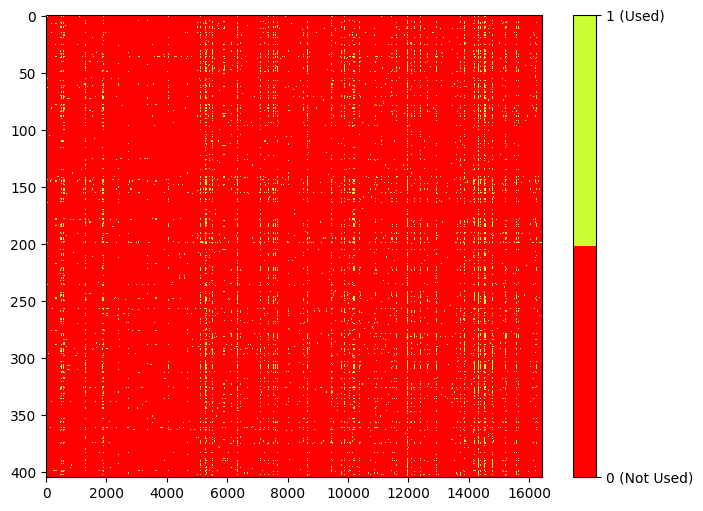

In [11]:
visualize_matrix(ground_truth)

We define a function to create an observation mask, which is a matrix of the same shape as our ground truth. A value of `1` indicates a known entry, `0` indicates an unknown entry. This matrix is then superimposed onto our ground truth matrix to create a training matrix for our algorithms.

In [12]:
np.random.seed(42)

def create_observation_mask(M, mask_percentage):
    n, m = M.shape
    total_entries = n * m
    mask_count = int(mask_percentage * total_entries / 100)

    # Randomly shuffle indices
    all_indices = np.arange(total_entries)
    np.random.shuffle(all_indices)

    # Select indices to retain
    mask_indices = all_indices[:mask_count]

    # Create observation mask
    O = np.ones_like(M, dtype=int)
    O.flat[mask_indices] = 0
    return O


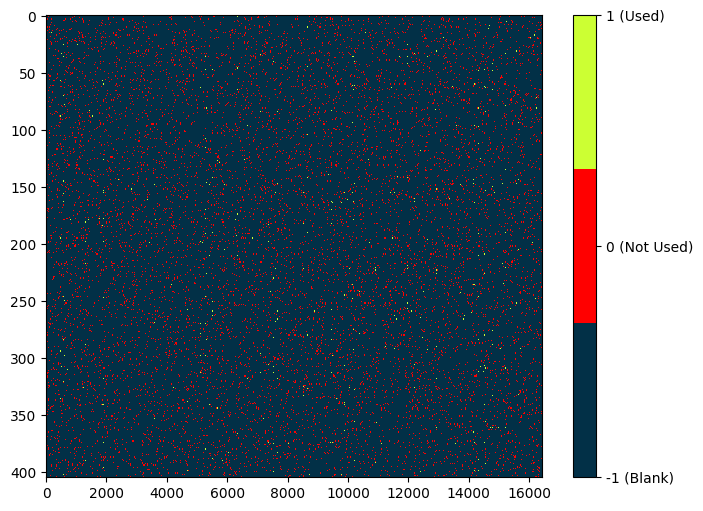

In [13]:
obs_mask = create_observation_mask(ground_truth, mask_percentage=95)
visualize_matrix(ground_truth, mask=obs_mask)

Here we implement the Memory based CF algorithm. We provide flexibility to use item or user based techniques. To measure similarity between items or users we perform a cosine similarity between the feature vectors. The prediction for the missing value is calculated using a weighted sum of ratings using the similarity scores we computed. The data is then normalized  to ensure proper scaling. Item-based predictions are further adjusted by adding the mean rating of each item, while user-based predictions incorporate user-wise mean ratings. 

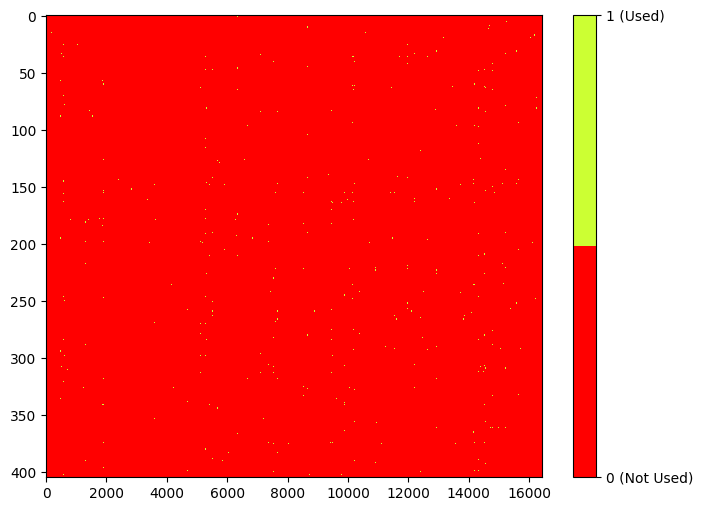

In [14]:


def predict_with_collaborative_filtering(training_matrix, similarity_type):
    matrix = training_matrix.copy()
    
    nan_mask = np.isnan(matrix)
    matrix[nan_mask] = 0
    
    if similarity_type == 'item':
        similarity = cosine_similarity(matrix.T)  # Item-item similarity
        mean_ratings = np.nanmean(training_matrix, axis=0)  # Item-wise mean
        prediction = np.dot(matrix, similarity) / (np.abs(similarity).sum(axis=1) + 1e-8)
    elif similarity_type == 'user':
        similarity = cosine_similarity(matrix)  # User-user similarity
        mean_ratings = np.nanmean(training_matrix, axis=1)  # User-wise mean
        prediction = np.dot(similarity, matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + 1e-8)
    
    if similarity_type == 'item':
        prediction += mean_ratings[np.newaxis, :]
    else:
        prediction += mean_ratings[:, np.newaxis]
    
    training_matrix[nan_mask] = prediction[nan_mask]
    return training_matrix

predicted_matrix = predict_with_collaborative_filtering(ground_truth * obs_mask, similarity_type='item')

visualize_matrix(predicted_matrix)

### Result

We use Root Mean Square Error to measure how closely the reconstructed matrix resembles the ground truth matrix 

In [15]:
def reconstruction_error(original, test):
    
    # Apply the mask to calculate the error only on specified elements
    difference = original - test
    squared_error = np.square(difference)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse


In [16]:
reconstruction_error(ground_truth, predicted_matrix)

0.18985931087867747

## Low Rank Matrix CF

This technique is based on the matrix completion algorithm taught in this course. We construct a ground truth matrix from our project and package data using `1`s and `0`s to represent projects using or not using dependencies. We mask this data to create very few known observations and then try to reconstruct the original matrix using low rank matrix factorization. 

In [17]:
# Load data

package_feats = load_data_from_json(package_features_cf_json)
project_data = load_data_from_json(project_dependencies_json)

# For each project remove dependencies that are not available
clean_project_data(project_data, package_feats.keys())

# Create ground truth matrix from project data
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

In [18]:
# Function to perform collaborative filtering



def collaborative_filtering(M, O, Otest, Mgt, lambdaNuc_factor=4, lambdaDF=1e1, max_iter=2000, tol=1e-1):
    # Initialization
    n, m = M.shape
    OM = O * M
    normOM = np.linalg.norm(OM, 2)
    lambdaNuc = normOM / lambdaNuc_factor
    
    # Identify zero rows and columns
    idx_zero_cols = np.where(np.sum(O, axis=0) < 1e-9)[0]
    idx_zero_rows = np.where(np.sum(O, axis=1) < 1e-9)[0]
    nb_zero_cols = len(idx_zero_cols)
    nb_zero_rows = len(idx_zero_rows)
    
    X = M.copy()
    Xb = X.copy()
    Y = np.zeros_like(M)
    normA = 1.0
    sigma = 1.0 / normA
    tau = 1.0 / normA
    diffX = 1e10
    min_nm = np.min([n, m])
    k = 0

    def shrink(S, thresh):
        return np.maximum(S - thresh, 0) - np.maximum(-S - thresh, 0)
    
    # Iterative process
    while k < max_iter and diffX > tol:
        k += 1
        
        # Update dual variable Y
        Y = Y + sigma * Xb
        U, S, V = np.linalg.svd(Y / sigma, full_matrices=False)
        Sdiag = shrink(S, lambdaNuc / sigma)
        Sshrink = np.zeros_like(M)
        for i in range(len(Sdiag)):
            Sshrink[i, i] = Sdiag[i]
        Y = Y - sigma * (U @ np.diag(Sdiag) @ V)
        
        # Update primal variable X
        Xold = X.copy()
        X = X - tau * Y
        X = (X + tau * lambdaDF * O * M) / (1 + tau * lambdaDF * O)
        
        # Fix issues with rows/columns with no observations
        r, c = np.where(X > 0.0)
        median = np.median(X[r, c]) if len(r) > 0 else 0
        if nb_zero_cols > 0:
            X[:, idx_zero_cols] = median
        if nb_zero_rows > 0:
            X[idx_zero_rows, :] = median
        
        # Update primal variable Xb
        Xb = 2 * X - Xold
        
        # Difference between iterations
        diffX = np.linalg.norm(X - Xold)
        
        # Reconstruction error
        err_test = np.sqrt(np.sum((Otest * (X - Mgt))**2)) / np.sum(Otest) * (n * m)
        
        # Visualization
        if not k % 2:
            clear_output(wait=True)
            # plt.figure(figsize=(8, 6))
            # plt.imshow(X, interpolation='nearest', cmap='jet')
            # plt.title(f'Collaborative Filtering\nIteration={k}\nReconstruction Error={round(err_test, 5)}')
            # plt.colorbar()
            # plt.show()
            # visualize_matrix(X)
            print(f'diffX: {diffX}')
    
    return X
    

In [19]:
# Setup params

M = ground_truth
O = obs_mask

reconstructed_matrix = collaborative_filtering(
    M=M,
    O=O,
    Otest=O,  # Use the same mask for testing in this case
    Mgt=M,
    lambdaNuc_factor=10,
    lambdaDF=1e1,
    max_iter=10,
    tol=1e-1
)

diffX: 14.272288686635472


#### Visualizing the reconstructed matrix

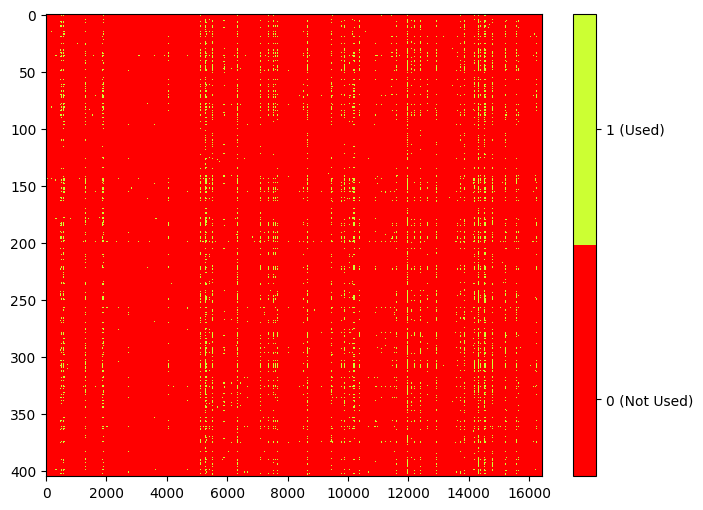

In [20]:
visualize_matrix(reconstructed_matrix)

In [21]:
reconstruction_error(ground_truth, reconstructed_matrix)

0.08638970308678999

## Page Rank

In this section we will use PageRank algorithm to recommend popular packages for projects. We construct a co-dependency graph of packages where an edge connects two nodes if they appear together as dependencies within the same project. We also enhance our graph by using weighted edges (based on how frequently a pair of packages appear together) and assigning node importance scores at initialization (using download count).

> **Note** - We could not construct the full co-dependency graph as it is too resource intensive. As a means of compressing the graph we picked the top k most popular dependencies of a project (based on download count) and created an edge between every pair of the selected dependencies to create our co-dependency graph

#### Construct Co-dependency graph

In [22]:
# build adjacency matrix using project data


def filter_top_by_download_count(packages, data, top=1500):
    packages.sort(key=lambda x: data[x]['download_count'], reverse=True)
    return packages[:top]


def create_co_dependency_graph(projects, package_data, limit=1500, include_edge_weights=False):
    # Initialize list to store edges
    edges = []
    
    for project, deps in projects.items():
        deps = filter_top_by_download_count(deps, package_data, top=limit)
        
        for dep1, dep2 in combinations(deps, 2):
            edges.append(tuple(sorted((dep1, dep2)))) 
    
    # Convert the set of edges to a list
    if not include_edge_weights:
        return list(edges)
    else:
        Counter(edges)

In [23]:
# Helper Functions for testing pagerank

def test_pagerank_all_projects(graph, project_data,package_data, alpha=0.1, weights=None, personalization=None):
    ranks = list(nx.pagerank(graph, alpha=alpha, weight=weights, personalization=personalization).items())
    ranks.sort(key=lambda x: x[1], reverse=True)
    
    top = set([p for p, s in ranks[:100]])
    
    # calculate score
    total = 0
    errors = []
    for p, deps in project_data.items():
        deps = set(deps)
        intersection = deps & top
        print(f"{p:70}\t{len(intersection)}/{len(deps)}")
        total += len(intersection)
        errors.append(len(deps - intersection))
        # dep_len += len(deps)
        
    
    
    print(f"----------\ntotal {total}")
    errors = np.array(errors)
    errors = np.sqrt(np.sum(errors)/(len(project_data.keys()) *  len(package_data.keys())))
    print("RMSE:", errors)

In [24]:
project_data = load_data_from_json(project_dependencies_json)
package_data = load_data_from_json(package_features_cf_json)
clean_project_data(project_data, package_data.keys())

edges = create_co_dependency_graph(project_data, package_data, limit=100)

In [25]:
edges_weighted = [(e1,e2,w) for (e1,e2),w in Counter(edges).items()]
edges_weighted_df = pd.DataFrame(edges_weighted, columns=['from', 'to', 'weight'])

G = nx.from_pandas_edgelist(edges_weighted_df, source='from', target='to', edge_attr='weight', create_using=nx.Graph)

In [26]:
print(len(G.edges))

147769


### Testing PageRank

To test our implementation of Pagerank we run PageRank for each project. If a project has `k` dependencies we consider the top `k` ranked packages from PageRank and compare those with the actual dependencies of the project. The error is the number of dependencies not predicted correctly. To measure the performance of our model we use the **Root Mean Square Error**

We use the same error metric for topic-specific PageRank (discussed in the following section)

In [27]:
# Default Pagerank

test_pagerank_all_projects(G, project_data,package_data)

homepage+gethomepage                                                  	40/612
blessed-contrib+yaronn                                                	23/206
webpack-dashboard+FormidableLabs                                      	46/805
d2-admin+d2-projects                                                  	60/1388
linux-dash+tariqbuilds                                                	6/15
gtop+aksakalli                                                        	12/91
antd-admin+zuiidea                                                    	12/64
roughViz+jwilber                                                      	2/17
freeboard+Freeboard                                                   	4/6
Ghost+TryGhost                                                        	71/3120
decap-cms+decaporg                                                    	73/2524
keystone-classic+keystonejs                                           	59/1041
relax+relax                                                          

In [28]:
# Pagerank with weighted edges

test_pagerank_all_projects(G, project_data,package_data, weights='weight')

homepage+gethomepage                                                  	52/612
blessed-contrib+yaronn                                                	36/206
webpack-dashboard+FormidableLabs                                      	58/805
d2-admin+d2-projects                                                  	69/1388
linux-dash+tariqbuilds                                                	5/15
gtop+aksakalli                                                        	19/91
antd-admin+zuiidea                                                    	13/64
roughViz+jwilber                                                      	2/17
freeboard+Freeboard                                                   	4/6
Ghost+TryGhost                                                        	79/3120
decap-cms+decaporg                                                    	83/2524
keystone-classic+keystonejs                                           	70/1041
relax+relax                                                          

In [29]:
# Pagerank using download_count as starting node importance scores

node_weights = {p: data["download_count"] for p, data in package_data.items()}
test_pagerank_all_projects(G, project_data,package_data, personalization=node_weights)

homepage+gethomepage                                                  	82/612
blessed-contrib+yaronn                                                	55/206
webpack-dashboard+FormidableLabs                                      	89/805
d2-admin+d2-projects                                                  	99/1388
linux-dash+tariqbuilds                                                	1/15
gtop+aksakalli                                                        	26/91
antd-admin+zuiidea                                                    	1/64
roughViz+jwilber                                                      	0/17
freeboard+Freeboard                                                   	0/6
Ghost+TryGhost                                                        	100/3120
decap-cms+decaporg                                                    	100/2524
keystone-classic+keystonejs                                           	88/1041
relax+relax                                                         

In [30]:
# Pagerank using personalization and weighted edges

test_pagerank_all_projects(G, project_data,package_data, weights='weight', personalization=node_weights)

homepage+gethomepage                                                  	84/612
blessed-contrib+yaronn                                                	55/206
webpack-dashboard+FormidableLabs                                      	91/805
d2-admin+d2-projects                                                  	100/1388
linux-dash+tariqbuilds                                                	1/15
gtop+aksakalli                                                        	26/91
antd-admin+zuiidea                                                    	1/64
roughViz+jwilber                                                      	0/17
freeboard+Freeboard                                                   	0/6
Ghost+TryGhost                                                        	100/3120
decap-cms+decaporg                                                    	100/2524
keystone-classic+keystonejs                                           	88/1041
relax+relax                                                        

### Topic-specific Pagerank using Keywords

For topic-specific pagerank we modify our inital node weights based on a similarity score (computed using Jaccard similarity) based on how many keywords a package's metadata has in common with an input set of keywords. For testing our model we run PageRank for all projects and use their `topics` as the input

In [31]:
project_df = pd.read_csv(project_details_csv).set_index('name')
topics = project_df['topics'].copy()
topics = topics.to_dict()

for p, k in topics.items():
    topics[p] = convert_str_to_list(k)

In [32]:
# define a function to calculate similarity scores based on keywords
def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)
    return len(a & b) / len(a | b)


def pagerank_keywords(graph, keyword_list: list, package_features, top=100, weights=None):
    if len(keyword_list) > 0:
        personalization = {pkg: jaccard_similarity(package_features[pkg]["keywords"], keyword_list)  for pkg in G.nodes}
        if sum(personalization.values()) == 0:
            personalization = {pkg: 1 for pkg in package_features.keys()}
        
        scores = nx.pagerank(graph, alpha=0.1, personalization=personalization, weight=weights)
        
    else:
        scores = nx.pagerank(graph, alpha=0.1, weight=weights)
        
    ranks = list(scores.items())
    ranks.sort(key=lambda x: x[1], reverse=True)
    return ranks[:top]


In [33]:
def test_pagerank_keywords_all_projects(graph, project_deps, project_topics, package_data, weights=None):
    total=0
    errors = []
    for project, keywords in project_topics.items():
        deps = set(project_deps[project])
        top = pagerank_keywords(graph, keywords, package_data, weights=weights,top=len(deps))
        top = set([p for p, s in top])
        
        
        intersection = deps & top
        print(f"{project:70}\t{len(intersection)}/{len(deps)}")
        total += len(intersection)
        
        errors.append(len(deps - intersection))
        
    print(f"----------\ntotal {total}")
    errors = np.array(errors)
    errors = np.sqrt(np.sum(errors)/(len(project_data.keys()) *  len(package_data.keys())))
    print("RMSE:", errors)
    

In [34]:
# Topic specific pagerank using only keywords

test_pagerank_keywords_all_projects(G, project_data, topics, package_data)

homepage+gethomepage                                                  	58/612
blessed-contrib+yaronn                                                	59/206
webpack-dashboard+FormidableLabs                                      	206/805
d2-admin+d2-projects                                                  	442/1388
linux-dash+tariqbuilds                                                	0/15
gtop+aksakalli                                                        	35/91
antd-admin+zuiidea                                                    	11/64
roughViz+jwilber                                                      	12/17
freeboard+Freeboard                                                   	0/6
Ghost+TryGhost                                                        	841/3120
decap-cms+decaporg                                                    	799/2524
keystone-classic+keystonejs                                           	369/1041
relax+relax                                                    

In [73]:
# Topic specific pagerank using keywords and weighted edges

test_pagerank_keywords_all_projects(G, project_data, topics, package_data, weights='weight')

homepage+gethomepage                                                  	228/612
----------
total 228
RMSE: 0.007595907596604862


### Results

- `V` - Vanilla PageRank
- `TS` - Topic-Specific PageRank
- `E` - PageRank with edge weights
- `P` - PageRank with personalization (node importance scores)

We ran each PageRank model for different upper limits of the number of packages chosen from each project while constructing the co-dependency graph. 

| **PageRank Model** | **RMSE (Limit=100)** | **RMSE (Limit=300)** | **RMSE (Limit=500)** |
|--------------------|----------------------|----------------------|----------------------|
| V                  | 0.18946835228967515  | 0.18716205274311482  | 0.1865130635372371   |
| V(E)               | 0.18840229196293373  | 0.18621596371394109  | 0.18573929194740293  |
| V(P)               | 0.18840229196293373  | 0.18621717403631108  | 0.1862615470922385   |
| V(E+P)             | 0.18625993371178068  | 0.18616149106301383  | 0.18617077271513052  |     
| TS                 | 0.1646278993694155   | 0.150243359227015    | 0.1443565967370671   |
| TS(E)              | 0.16557937029977407  | 0.15009627611749693  | 0.1420376751504513   |



Some points to note from the result - 
- We can see that a decreasing trend in error as we increase the upper limit of the number of packages of a project considered. 
- Topic specific PageRank seems to consistently outperform Vanilla PageRank yielding a much lower RMSE value, across all variations. 

Graph details :
- Limit = 100: Number of edges = 147769
- Limit = 300: Number of edges = 972412
- Limit = 500: Number of edges = 2679566


## Graph Content Filtering

In this section we try to augment our CF model using KNN graphs for projects and packages. The idea is that similar projects will use similar dependencies.

In [35]:
package_feats = load_data_from_json(package_features_cf_json)
project_data = load_data_from_json(project_dependencies_json)

# For each project remove dependencies that are not available
clean_project_data(project_data, package_feats.keys())

# Create ground truth matrix from project data
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

#### Embedding Text Features

Our project and package metadata includes text features like names, keywords and descriptions. To convert these features to numerical embeddings we will use [BERT](https://www.sbert.net/index.html). BERT will convert a string into embeddings of size 384. Thus each, text feature will be converted to a vector of size 384

In [36]:


def get_bert_embeddings_batch(data: List[Union[List[str], str]], model=None, batch_size=32, desc="Processing Batches") -> np.ndarray:
    # Load BERT model if not provided
    if model is None:
        model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient BERT model

    # Preprocess the data: combine keywords into strings if necessary
    processed_data = []
    for item in data:
        if isinstance(item, list):  # If the input is a list of keywords
            if not item:  # Handle empty lists
                processed_data.append("")
            else:
                processed_data.append(" ".join(item))  # Combine keywords into a single string
        elif isinstance(item, str):  # If the input is already a string (description)
            processed_data.append(item.strip())
        else:
            raise ValueError("Each item in the input data must be either a list of strings or a single string.")

    # Handle empty input cases
    zero_vector = np.zeros(model.get_sentence_embedding_dimension())
    if all(not item for item in processed_data):  # All inputs are empty
        return np.array([zero_vector] * len(data))

    # Compute embeddings in batches
    embeddings = []
    num_batches = (len(processed_data) + batch_size - 1) // batch_size  # Calculate total number of batches
    for i in range(0, len(processed_data), batch_size):
        batch = processed_data[i:i + batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)  # Batch encoding
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)


In [37]:
# Function to create embeddings for text features

def get_embeddings_for_features(data, feats):
    order = sorted(data.keys())
    
    result = {
        "key_order": order,
    }
    
    for feat in feats:
        if feat == "name":
            embeddings = get_bert_embeddings_batch(order, desc="Name Batches")
        else:
            embeddings = get_bert_embeddings_batch(order, desc=f"{feat} Batches")
        result[f"{feat}_embeddings"] = embeddings
        
    return result

#### Computing Similarity

Both projects and packages contain numerical and text features. Typically each numerical feature will be a single column while each text feature will contain 384 columns. To avoid biasing cosine similarity in favour of the text features we group text features together, numerical features together and compute cosine similarity for each. Then the final similarity score is obtained by taking a weighted sum of both the scores in such a manner that each original feature contributes equally to the final similarity score.

In [38]:
# Function to create a similarity score matrix

def compute_similarity_scores(data, numerical_features: list, text_features: list):
    order = sorted(data.keys())
    nf = len(numerical_features)
    nt = len(text_features)
    
    # Compute scores for numerical features
    scaler = MaxAbsScaler()
    
    num_feat_vecs = []
    for ft in numerical_features:
        arr = np.array([data[p][ft] for p in order])
        num_feat_vecs.append(arr.reshape(-1,1))
        
    num_feat_vecs = np.hstack(num_feat_vecs)
    num_feat_vecs = scaler.fit_transform(num_feat_vecs)
    num_feat_vec_similarity = cosine_similarity(num_feat_vecs)
    
    # Compute scores for text features
    embeddings = get_embeddings_for_features(data, text_features)
    del embeddings["key_order"]
    text_feat_vec = np.hstack([embeddings[f"{ft}_embeddings"] for ft in text_features])
    text_feat_vec_similarity = cosine_similarity(text_feat_vec)
    
    # Take weighted sum
    wt = 1.0 / (nf + nt)
    
    scores = (nf * wt * num_feat_vec_similarity) + (nt * wt * text_feat_vec_similarity)
    
    return scores

#### Constructing and Visualizing KNN graph based on Similarity Score Matrix

In [39]:
# Function to construct KNN graph

def create_knn_graph(score_matrix: np.ndarray, k: int) -> nx.Graph:
    # Initialize the graph
    num_nodes = score_matrix.shape[0]
    knn_graph = nx.Graph()

    # Add nodes to the graph
    knn_graph.add_nodes_from(range(num_nodes))

    # Find the k-nearest neighbors for each node
    for i in range(num_nodes):
        # Get the scores for the current node
        scores = score_matrix[i]
        
        # Exclude self-scores and find the k smallest distances
        nearest_neighbors = np.argsort(scores)[-k-1:-1] # Skip the first one (itself)
        nearest_neighbors = nearest_neighbors.reshape((-1, 1))
        
        # Add edges to the graph
        for neighbor in nearest_neighbors:
            if neighbor[0] != i:
                knn_graph.add_edge(i, neighbor[0], weight=1)

    return knn_graph


In [40]:
# Function to visualize KNN graph

def visualize_knn_graph(graph, node_subset=None, title="KNN Graph", node_size=50, show_labels=True):
    
    # Subset the graph if needed
    if node_subset:
        subgraph = graph.subgraph(node_subset)
    else:
        subgraph = graph

    # Choose a layout
    pos = nx.spring_layout(subgraph, seed=42)  # Spring layout for visually appealing positions

    # Draw the graph
    plt.figure(figsize=(6, 6))
    nx.draw(
        subgraph,
        pos,
        with_labels=show_labels,
        node_size=node_size,
        font_size=8,
        edge_color="gray",
        node_color="skyblue",
    )

    plt.title(title)
    plt.show()


In [41]:
similarity_matrix = compute_similarity_scores(package_data, numerical_features=["download_count"], text_features=["name", "keywords", "description"])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\vaibh\IdeaProjects\Python\Testing\graphml-package-dependency-recommendation\venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vaibh\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

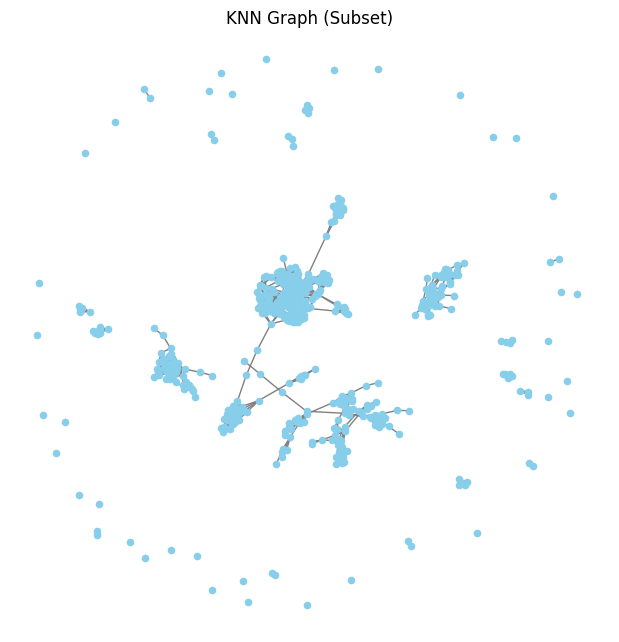

In [42]:
package_knn_graph = create_knn_graph(similarity_matrix, 5)
visualize_knn_graph(package_knn_graph, node_subset=list(range(500)), title="KNN Graph (Subset)", node_size=20, show_labels=False)

In [43]:
print(len(package_data))

16433


#### Build KNN graph for projects

In [44]:
# Step 0 - load data and create a dict

filter_project_list = project_data.keys()
project_df = pd.read_csv(project_details_csv)
project_df = project_df[project_df['name'].isin(filter_project_list)]
project_df.drop_duplicates("name", keep='last', inplace=True)
project_df.set_index("name", inplace=True)
project_feats = project_df.to_dict(orient="index")

for p, f in project_feats.items():
    project_feats[p]["topics"] = convert_str_to_list(f["topics"])

In [45]:
project_similarity_matrix = compute_similarity_scores(project_feats, numerical_features=["size", "stars", "forks"], text_features=["name", "topics", "description"])

In [46]:
project_knn_graph = create_knn_graph(project_similarity_matrix, 3)

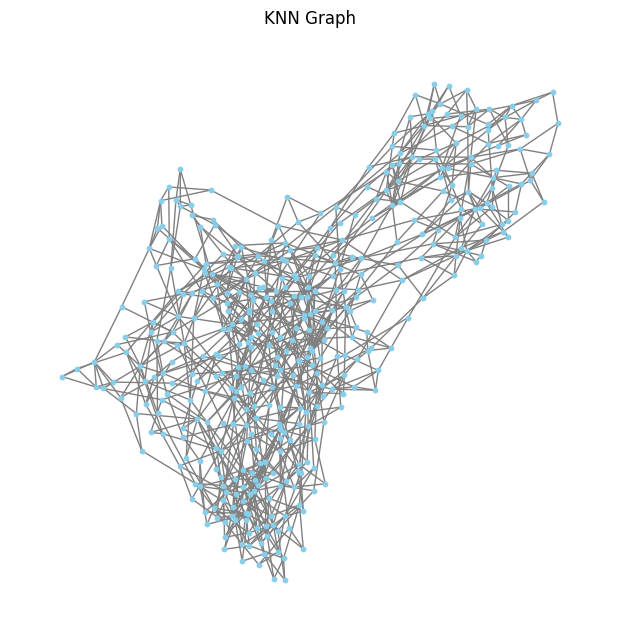

In [47]:
visualize_knn_graph(project_knn_graph, show_labels=False, node_size=10)

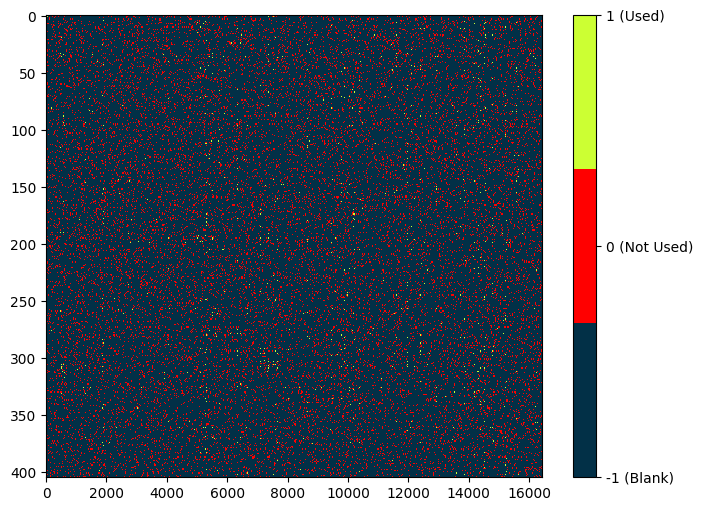

In [48]:
obs_mask = create_observation_mask(ground_truth, mask_percentage=90)
visualize_matrix(ground_truth, mask=obs_mask)

## Perform Content Filtering Algorithm

This algorithm is based on the Content Filtering algorithm taught in the course.

In [49]:
def graph_laplacian(W, normalized=True):
    W = W.astype(np.float64)
    
    # Degree vector
    d = W.sum(axis=0, dtype=W.dtype)
    
    # Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype)) # d += epsilon
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D
    return L

#### Computation of Kronecker Product

For this task our Laplacian matrices were of dimensions ~(450, 16000). When taking the Kronecker product of this matrix (`A` in `Ax=b`) its size blew up to ~(7,000,000, 7,000,000). This is impossible to compute with our resources so we needed to find a workaround. From our research we discovered that performing conjugate gradient does not explicity require `A`, it simply requires the product `A.x`. `scipy.sparse.linalg.cg` provides the functionality of using a `LinearOperator` which uses a function call to estimate the transformation `A.x` without having to explicity compute `A`. With further research we were able to break down the the Kronecker product computation and use this estimation instead which allowed us to feasibly perform our matrix reconstruction.

In [85]:

def content_filtering_with_dirichlet_linear_operator(O, M, Wrow, Wcol, lambdaDir=1e-1, lambdaDF=1e2, alpha=0.02, tol=1e-6, maxiter=100):
    
    # Compute graph Laplacians
    Lr = graph_laplacian(Wrow)  # Row graph Laplacian (n x n)
    Lc = graph_laplacian(Wcol)  # Column graph Laplacian (m x m)

    n, m = O.shape
    print(f"n = {n}, m = {m}")
    print(f"Lr.shape = {Lr.shape}")
    print(f"Lc.shape = {Lc.shape}")
    print("Lr.nnz:", Lr.nnz)  
    print("Lc.nnz:", Lc.nnz) 


    # Define a LinearOperator for A
    def apply_A(x):
        """
        Apply the matrix-vector product A @ x without explicitly constructing A.
        """
        X = x.reshape((n, m))  # Reshape x into (n, m) matrix
        row_part = (1.0 - alpha) * (Lr @ X)  # Apply row Laplacian
        col_part = alpha * (X @ Lc.T)  # Apply column Laplacian
        result = lambdaDir * (row_part + col_part)  # Combine with lambdaDir
        vecO = np.ravel(O)  # Flatten observation mask
        result = result.ravel() + lambdaDF * vecO * x  # Add regularization term
        return result

    A = LinearOperator(
        shape=(n * m, n * m),  # Full matrix shape
        matvec=apply_A,  # Function to compute A @ x
        dtype=np.float64
    )

    # Prepare the right-hand side vector b
    vecM = np.ravel(M)  # Flatten observed values matrix
    vecO = np.ravel(O)  # Flatten observation mask
    matO = diags(vecO, 0, shape=(n * m, n * m), dtype=np.float64)  # Diagonal matrix for observed values
    b = lambdaDF * (matO @ vecM)  # Right-hand side vector

    print(f"vecO.shape = {vecO.shape}")
    print(f"matO.shape = {matO.shape}")


    # Solve Ax = b using Conjugate Gradient
    try:
        x, info = cg(A, b, x0=np.zeros_like(b), tol=tol, maxiter=maxiter)
    except TypeError:
        x, info = cg(A, b, x0=np.zeros_like(b), rtol=tol, maxiter=maxiter)

    if info != 0:
        raise ValueError(f"Conjugate Gradient solver did not converge (info={info}).")

    # Reshape solution back to matrix form
    X = x.reshape((n, m))  # Reshape x into (n, m) matrix

    return X


In [86]:
# Set params
O = obs_mask
M = ground_truth
Wrow = csr_matrix(nx.adjacency_matrix(project_knn_graph))
Wcol = csr_matrix(nx.adjacency_matrix(package_knn_graph))

print(Wrow.shape)
print(Wcol.shape)

lambdaDir=1e-1
lambdaDF=1e3
alpha=0.02
tol=1e-9

(405, 405)
(16433, 16433)


In [87]:
reconstructed_matrix = content_filtering_with_dirichlet_linear_operator(O, M, Wrow, Wcol, lambdaDir=lambdaDir, lambdaDF=lambdaDF, tol=tol, alpha=alpha, maxiter=1000)

n = 405, m = 16433
Lr.shape = (405, 405)
Lc.shape = (16433, 16433)
Lr.nnz: 2203
Lc.nnz: 138545
vecO.shape = (6655365,)
matO.shape = (6655365, 6655365)


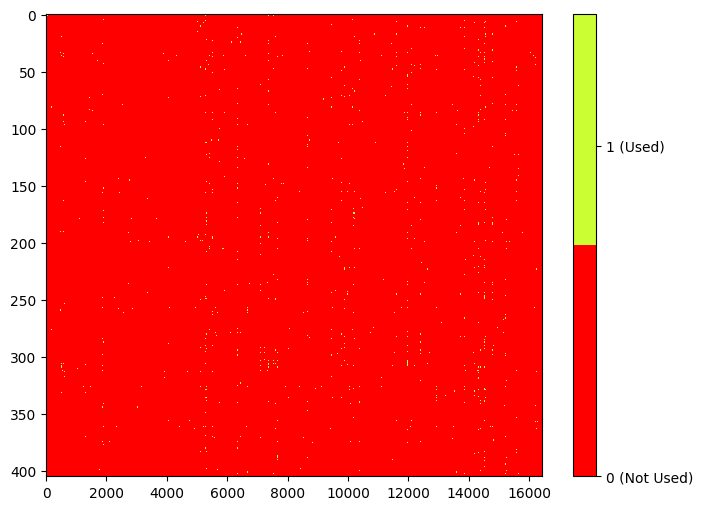

In [79]:
visualize_matrix(reconstructed_matrix)

In [88]:
reconstruction_error(ground_truth, reconstructed_matrix)

0.1661170458956928

## Analysis of Results

The following table shows the best results for each of our models


| **Model**                                             |  **RMSE**  | **Time taken for all predictions** |
|-------------------------------------------------------|------------|------------------------------------|
| Memory based Collaborative Filtering (Item based)     |  0.18985931087867747 | 8.699 s                            |
| Low-Rank Matrix Collaborative Filtering               |  0.08638970308679021 | 21.549 s                           |
| PageRank (Topic Specific + Weighted)             				 |  0.1443565967370671 | 29 min 31 s                        |
| Graph based Content Filtering             			         |  0.1661170458956928 | 16.360 s                           |   


### Model Analysis
- **Memory based Collaborative Filtering (Item based)** : This algorithm relies on a similarity metric (cosine similarity in our case) to make predictions. Due to this there are no computationally intensive steps like the other models, which makes this the most efficient model. However, its error is the highest among them all. This could be due to the sparsity of our ground truth matrix, which leads to insufficient data for computing similarity measures between the items.
- **Low-Rank Matrix Collaborative Filtering**  : This model gave us the lowest error for predictions, while also keeping its runtime at a reasonable level. In spite of the sparse data, this model seems to be able to generalize well.
- **PageRank (Topic Specific + Weighted)**  : This algorithm achieved a moderately low error but exhibited a significantly higher runtime compared to the other models, making it less scalable for large datasets. It's important to note that the high runtime stems from running PageRank individually for each project, with each run averaging around 4 seconds. Consequently, this algorithm could be a viable choice for predicting or recommending packages when dealing with a smaller sample size of projects.
- **Graph based Content Filtering** : This model seems to be the most balanced in terms of error and runtime. It performs better than Memory CF, probably because it can take into account local and global patterns while memory based CF only focuses on local similarities.  



## Future Scope
The current scope of our project is only limited to NPM package recommendation for Javascript based projects. However, our models could be extended to support multiple package-managers like Maven, Pip, etc. for languages like Java, Python, etc. In addition to this some possible extensions in functionality could be: 
1. Conflict resolution: By including versioning and dependency information in our dataset and model building process, we could build models which also recommend the version of the package needed to resolve version conflicts, which could be very useful in large-scale projects.
2. Automated Dependency Management: The model could be integrated into existing build tools like NPM, Maven so that it could automatically suggest recommended packages and resolve conflicts

